# GNN with Positional Encoding
---
> Graph neural network model for vertex dynamics and tension prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import torch
from torch_geometric.data import Data, DataLoader
from collections import OrderedDict
from simgnn.datasets import clear_processed, VertexDynamics, HaraMovies, HaraAblation
import torch_geometric.transforms as T
from simgnn.transforms import Pos2Vec, ScaleVelocity, ScaleTension, RecoilAsTension, \
                              AppendReversedEdges, AppendDiff_x, Reshape_x , AppendEdgeLen, PosEnc, PosEncNeRF

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use(['seaborn-paper', 'seaborn-ticks']) # use seaborn-talk for presentations
%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
# matplotlib.rcParams['font.size']= 16 # use 14 for presentation

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
print(f'Defaults:\n |-device: {device}\n |-dtype : {dtype}')

Defaults:
 |-device: cuda
 |-dtype : torch.float32


## Notes for normalisation param-s:

- Use `simgnn.transforms` to normalise real--Hara movies and ablation,  and simulated movies.
- For ablation movies, convert to  HaraMovies length scale (pixels) and use same `l_av` as for HaraMovies dataset.

---
|Dataset| Avg. edge len.|Tension/Recoil| Transforms (Normalisation)|Notes|
|:---:|:---:|---:|:---|:---:|
|`single_distr_sims` | 1.08 a.u. | range = [0.00131, 4.26]; sd=0.637; median=0.305; mean=0.578; | `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/o base tension |
|`unimodal_wbasetens_sims` | 0.906 a.u. | range=[0.407, 5.47]; sd=0.729; median=1.48; mean=1.6| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)]`| synthetic; w/ non-zero base tension |
|`HaraMovies`  | 26.32 pixels||`[Pos2Vec(scale=10*26.32)`, `ScaleVelocity(0.5*26.32)]`| tissue movies w/o force data|
|`HaraAblation`|$26.32\cdot\frac{0.4}{0.21}$ pixels| range=[0.0239, 2.61]; sd=0.651; median=0.673; mean=0.826 | `[Pos2Vec(scale=10*50.13), ScaleVelocity(0.5*50.13)]`| short movies w/ recoil data; frame rate:dataset contains vertex positions only from every 10th frame |


---
- **Input features for transforms**

In [55]:
# Data normalisation param-s : sim="default" for simulation data

# 'sim' : default edge length param for all sim-s; l_0 (same for all sim-s)
# '***_sims' : dataset tension param-s;

# Average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

# Stat-s for raw tension/recoil values
t_av = {'sim':0.6, 'single_distr_sims': 0.58, 'unimodal_wbasetens_sims': 1.6, 'abln': 0.83}
t_sd = {'sim':0.63, 'single_distr_sims': 0.64, 'unimodal_wbasetens_sims':0.73 , 'abln': 0.65}

# Input features
window_size = 5
print(f'> Set features window size to --> {window_size}')
sma_lag_time = 4 # SMA_n : n=sma_lag_time+1
print(f'> Set n for SMA_n --> {sma_lag_time+1}')

> Set features window size to --> 5
> Set n for SMA_n --> 5


---
## Experiment Param-s

In [59]:
experiment = {
    'noise' : False, # None/ torch.normal /...
    'noise_params': {'frac':0.5,
                     'coeffs': {'x': l_0['sim'],
                                'pos': l_0['sim']},
                     'noise_args':[0, 0.03]
                    },
    
    'diffX'       : True,
    'diffX_params': {'norm':True },
    
    'posenc'        : False, # PosEnc/PosEncNeRF
    'posenc_params' : {'b' : 1.2,
                       'm' : 8
                      }
    }

In [60]:
# dir to save models
model_dir_ = Path('./simgnn_data/saved_models/paper') / 'position_encoding'

model_dir_.mkdir(parents=True, exist_ok=True)    

## Data, Stat-s, Transforms

### Datasets

- **Normalisation param-s (transforms)**

```python
Tnorms['sim'] = T.Compose([ AddPosNoise(pos_noise, frac=frac, coeffs=coeffs, noise_args=noise_args),
                         Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']), Reshape_x((-1,window_size*2)) ] )

Tnorms['sim_val'] = T.Compose([ Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']), Reshape_x((-1,window_size*2)) ] )
```

In [73]:
DATASETS = ['train', 'val', 'val2', 'hara', 'abln']

Tnrm = {k : [] for k in DATASETS}

# Dataset-specific normalisations

if experiment['noise']:
    # Training data noise (corrupts position information)
    Tnrm['train'].append(AddPosNoise(experiment['noise'], **experiment['noise_params']))

# Normalisations
for k, k_name in zip(['train', 'val', 'val2'],
                     ['unimodal_wbasetens_sims', 'unimodal_wbasetens_sims',
                      'single_distr_sims']):
    Tnrm[k].extend( [Pos2Vec(scale=l_0['sim']), # position to edge features (direction)
                     ScaleVelocity(l_0['sim']), # node x and y
                     ScaleTension(t_sd[k_name], shift=t_av[k_name]) # tensions
                     ])

# Hara ablation dataset
Tnrm['abln'].extend([Pos2Vec(scale=l_0['abln']), ScaleVelocity(l_0['abln']), RecoilAsTension() ])
# Hara movie dataset
Tnrm['hara'].extend([Pos2Vec(scale=l_0['hara']), ScaleVelocity(l_0['hara']) ])

# Prepare inputs

# Node and Edge Feature Transforms
# Convert to undirected graph and append "edge features"
for k in Tnrm:
    # to undirected graph: add e_ji for all e_ij
    Tnrm[k].append(AppendReversedEdges())
    
    if experiment['diffX']:
        # Add edge features
        Tnrm[k].append(AppendDiff_x(**experiment['diffX_params'])) # DiffX feature
    
    # flatten  node features
    Tnrm[k].append(Reshape_x((-1,window_size*2)))
    
    if experiment['posenc']:
        # positional encoding (Fourier features)
        Tnrm[k].append(experiment['posenc'](**experiment['posenc_params']))
    
    # # miscellaneous variables
    # Tnrm[k].append(AppendEdgeLen(norm=True, scale=l_0[k])) # for edge masks (not an edge feature)
    
    # compose a torch_geometric transform obj 
    Tnrm[k] = T.Compose(Tnrm[k])

In [74]:
Tnrm['abln']

Compose([
    Pos2Vec(norm=True, scale=50.13, cat=False, pos_noise=None, noise_args=[], noise_kwargs={}),
    ScaleVelocity(scale=50.13),
    RecoilAsTension(),
    AppendReversedEdges(reverse_attr=True, reverse_tension=False, edge_id=True),
    AppendDiff_x(norm=True),
    Reshape_x((-1, 10)),
])

- **Load datasets**

In [75]:
data_root = Path('simgnn_data')

# dataset locations
datasets = {'train' : 'unimodal_wbasetens_sims/train', 
            'val'   : 'unimodal_wbasetens_sims/val',
            'train2': 'single_distr_sims/train', 
            'val2'  : 'single_distr_sims/val',
            'hara'  : 'hara_movies_as_sep_datasets/hara_seg001',
            'abln'  : 'hara_ablation',
           }

# paths to processed datasets
dataset_paths = [data_root / datasets[dset] / 'processed' for dset in datasets]

dataset_legend={'train': 'Train(sim1)',
                'val': r'Supervised ($\mathcal{D}_{sim1}$)',
                'val2': r'Sim2sim ($\mathcal{D}_{sim2})$',
                'H1': r'Sim2real ($\mathcal{H}_1$)',
                'A': r'Sim2real ($v_{recoil}$)',
                'sim1mov': r'Supervised ($\mathcal{D}_{sim1}$)',
                'sim2mov': r'Sim2sim ($\mathcal{D}_{sim2})$'
               }

if one of these is changed: `w`, SMA `lag` time, delete the old *processed* dataset files with old `w` or `lag`

In [ ]:
# clear processed data (required for clearing older transformations)
# USE when changing `window_size` or `sma_lag_time`
# clear_processed(dataset_paths, verbose=True)

Initialise datasets (clear processed data if necessary):

In [126]:
datasets_dict = {}

# Simulation datasets
# w/ base contractility
datasets_dict['train'] = VertexDynamics(str(data_root/datasets['train']), window_size=window_size, transform=Tnrm['train'] )

datasets_dict['val'] = VertexDynamics(str(data_root/datasets['val']), window_size=window_size, transform=Tnrm['val'] )

# w/o base contractility
datasets_dict['val2'] = VertexDynamics(str(data_root/datasets['val2']), window_size=window_size, transform=Tnrm['val2'] )

# Amnioserosa datasets
# Movies

# datasets_dict['H'] = HaraMovies('simgnn_data/hara_movies/',window_size=window_size, transform=Tnrm['hara'],
#                                 smoothing=True, sma_lag_time=sma_lag_time)
datasets_dict['H1'] = HaraMovies(str(data_root/datasets['hara']), window_size=window_size, transform=Tnrm['hara'],
                                 smoothing=True, sma_lag_time=sma_lag_time)

# Laser ablation measurements
datasets_dict['A'] = HaraAblation(str(data_root/datasets['abln']), window_size=window_size, transform=Tnrm['abln'],
                                  smoothing=True, sma_lag_time= 3 )

# temporary fix for last frame bug (last frame: velocities==0)
# remove last movie frames (2 movies)
datasets_dict['val'] = datasets_dict['val'][:len(datasets_dict['val'])//2] + datasets_dict['val'][len(datasets_dict['val'])//2:-1]

datasets_dict['val2'] = datasets_dict['val2'][:len(datasets_dict['val2'])//2]+datasets_dict['val2'][len(datasets_dict['val2'])//2:-1]

---
Positional Encoding

Reading
1. [Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains](https://bmild.github.io/fourfeat/index.html)
    - colab nb https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb
1. [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
1. Related:
    - [NeRF](https://www.matthewtancik.com/nerf)
    - [Multi-scale NeRF](https://jonbarron.info/mipnerf/)
    - [Learned initialisation](https://www.matthewtancik.com/learnit)

# Build and Train GNN Model

In [127]:
from simgnn.train import train_model, write_log, load_log, plot_losses
from simgnn.train import predict, predict_batch, plot_velocity_predictions, plot_tension_prediction
from simgnn.train import predict_abln_tension, predict_dataset_tension

from scipy.stats import pearsonr


# from simgnn.nn import mlp, IndependentBlock, MessageBlock, dims_to_dict, Encode_Process_Decode
from simgnn.models import get_simple_gnn, construct_simple_gnn, GraphEncoder, GraphDecoder, GraphProcessor

***Change `b` in the PosEnc to find a suitable scale for encoding features***

In [128]:
num_x_dims = datasets_dict['train'][0].x.size(-1)
num_edge_dims = datasets_dict['train'][0].edge_attr.size(-1)

In [129]:
torch.manual_seed(42)

# GNN architecture (if dim is `int` latent dims nodes=edges)
# -----
n_blocks = 3 # N_blocks
dropout_p = 0 #0.05 # dropout for hidden layers & GN blocks (if any)
is_residual = True

input_dims = OrderedDict([('node', num_x_dims), ('edge', num_edge_dims)])

net = get_simple_gnn(n_blocks=n_blocks, input_dims=input_dims,
                     dropout_p=dropout_p, is_residual=is_residual, device=device)

unique_id = f'GNN{n_blocks}{"_res" if is_residual else ""}'  # unique name for the model
unique_id += f"_DiffX"
#     unique_id += f"_IgnrShrtEdge"
#     unique_id += f"_noise"
unique_id += f"_dropout{dropout_p}" if dropout_p>0 else ""
print('unique_id:', unique_id)

unique_id: GNN3_res_DiffX


ignore_short_edges, edge_len_threshold: False None
GNN3_res_DiffX_bs2w5_30epochs
---
Training param-s: #epochs=30, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=ReduceLROnPlateau, return_best=False
---
Epoch 0/29: train_loss_tot=  0.6003; train_loss_y=0.003524; train_loss_T=  0.5968; |val_loss_tot=  0.4982; |6s
Epoch 1/29: train_loss_tot=  0.4753; train_loss_y=0.001302; train_loss_T=   0.474; |val_loss_tot=  0.4643; |11s
Epoch 2/29: train_loss_tot=  0.4581; train_loss_y=0.0007238; train_loss_T=  0.4574; |val_loss_tot=  0.4623; |17s
Epoch 3/29: train_loss_tot=   0.458; train_loss_y=0.0007227; train_loss_T=  0.4573; |val_loss_tot=  0.4548; |23s
Epoch 4/29: train_loss_tot=  0.4483; train_loss_y=0.0007582; train_loss_T=  0.4475; |val_loss_tot=  0.4483; |29s
Epoch 5/29: train_loss_tot=  0.4415; train_loss_y=0.0008024; train_loss_T=  0.4407; |val_loss_tot=  0.4405; |35s
Epoch 6/29: train_loss_tot=  0.4366; train_loss_y=0.000903; train_loss_T=  0.4357; |val_loss_tot=  0.4469; |42s
Epoch 7

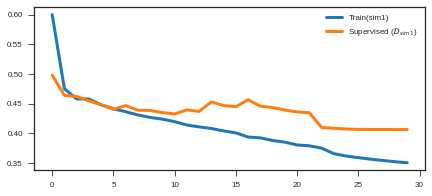

In [130]:
# Training param-s & Data loaders:
# -----
num_epochs = 30
lr = 0.001
bs = 2
loss_func = torch.nn.MSELoss(reduction='mean')

opt = torch.optim.Adam(net.parameters(), lr=lr) # SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min')

# in order to track the batch id for var-s add its key to "follow_batch":
loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs),
           'val':    DataLoader(datasets_dict['val'],  batch_size=bs)}
# this tracks batch id for "cell_pressures_batch" and "edge_index_batch" in addition to node batch ids

model_states = list(loaders.keys())
use_force_loss = {'train':[True,False], 
                  'val':[True, False],
                  'val2':[True,False] ,
                  'abln':[True,False] ,
                  'hara' : [False, False]
                 }# [tension, pressure]

return_best = False
# #     ignore_short_edges, edge_len_threshold = False, 10**-2
ignore_short_edges, edge_len_threshold = False, None
print('ignore_short_edges, edge_len_threshold:',ignore_short_edges, edge_len_threshold)


model_name = f'{unique_id}_bs{bs}w{window_size}{"best" if return_best else ""}' # adding date: datetime.datetime.now().strftime('%d%m%Y_%H%M%S')+
model_name = model_name+f'_{num_epochs}epochs'

print(model_name,end='\n---\n')

net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=scheduler, device=device, model_states = model_states,
                             loss_func = loss_func, use_force_loss=use_force_loss, return_best=return_best,
                             ignore_short_edges = ignore_short_edges, edge_len_threshold = edge_len_threshold)

# plot losses
plot_losses(train_log, loaders, dataset_legend, figsize=[7,3])
plt.show()

In [ ]:
# # Save trained model # # #
save_dir = 'simgnn_data/saved_models/thesis/tension_GN_sim2real/'
gnn_fname = f'{path.join(save_dir, model_name)}_net_{k}.pkl'

# write_log(f'{path.join(save_dir, model_name)}_train_log_{k}.pkl',train_log)
# torch.save(net.state_dict(), gnn_fname)
# print(f'Model weights saved in \n{gnn_fname}') 

train_loss_tot , 0.3718146903199474
train_loss_y , 0.0007949542308710323
train_loss_T , 0.37101973608907635
train_loss_P , 0.0
val_loss_tot , 0.46729350219532684
val_loss_y , 0.0007278463667015774
val_loss_T , 0.46656565582862525
val_loss_P , 0.0
val2_loss_tot , 0.5490871532578475
val2_loss_y , 0.0008912337497679735
val2_loss_T , 0.5481959195080796
val2_loss_P , 0.0
H1_loss_tot , 0.00016851510579993085
H1_loss_y , 0.00016851510579993085
H1_loss_T , 0.0
H1_loss_P , 0.0



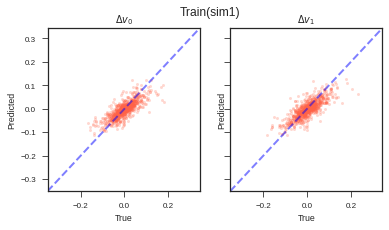

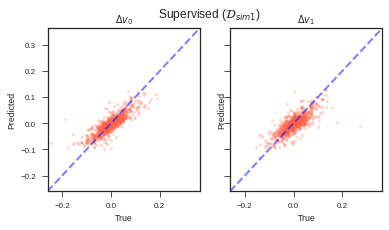

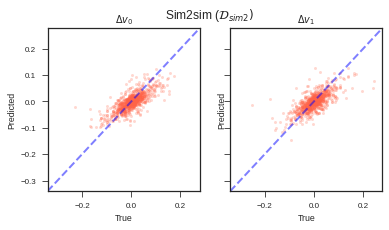

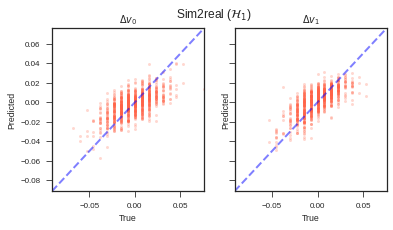

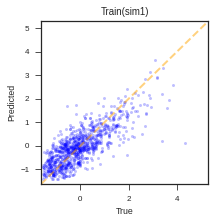

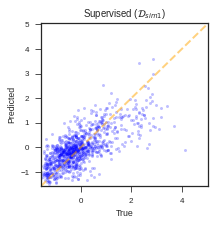

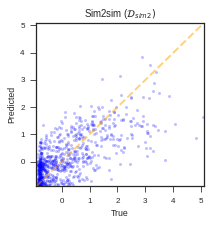

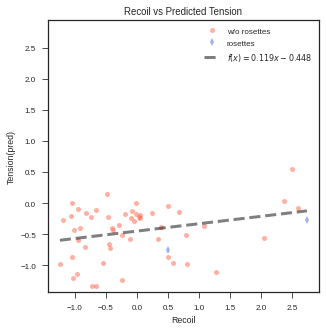

- - - - - - - - - - -
NO___rosettes : R,p=(0.2683811047160247, 0.05438792248518986)
WITH_rosettes : R,p=(0.26209965883979963, 0.05554574092378411)
- - - - - - - - - - -


In [115]:
# compute predictions and plot them
# vel-y, tens, pres
bs = 2

pred_out, tgt_out, sample_losses = predict_batch(net,
                                                 {'train' : DataLoader(datasets_dict['train'], batch_size=bs),
                                                  'val':    DataLoader(datasets_dict['val'],  batch_size=bs),
                                                  'val2':   DataLoader(datasets_dict['val2'], batch_size=bs),
                                                  'H1':   DataLoader(datasets_dict['H1'], batch_size=bs),
                                                 },
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {'train': True,
                                                                   'val': True,
                                                                   'val2': True,
                                                                   'H1' : False,
                                                                   'A':True
                                                                  },
                                                 return_losses = True, device=device)
print(''.join([f'{k} , {sample_losses[k]}\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend, subplots_kw={'figsize':[6,3]})

plot_tension_prediction(pred_out[1], tgt_out[1], dataset_legend, figure_kw={'figsize':[3,3]})

# # # # # # # # # # # # # #
# # # Hara Ablation # # # #
# # # # # # # # # # # # # #
Abln_p, Abln_t, is_ros_ = predict_abln_tension(net, datasets_dict['A'], device=device)

m1,m2 = np.polyfit(Abln_t[~is_ros_], Abln_p[~is_ros_], 1)
y_fit = np.array([min(Abln_t),max(Abln_t)])*m1+m2

plt.figure(figsize=[5,5])
ax = plt.gca()
ax.plot(Abln_t[~is_ros_], Abln_p[~is_ros_], 'o', mfc='tomato', ms=5, alpha=.5, label='w/o rosettes')
ax.plot(Abln_t[is_ros_], Abln_p[is_ros_], 'd', mfc='royalblue', ms=5, alpha=.5, label='rosettes')

ax.plot([min(Abln_t),max(Abln_t)], y_fit, 'k--',lw=3, alpha=.5, label=f'$f(x)={m1:.3f}x{"+" if m2>0 else "-"}{np.abs(m2):.3f}$')
ax.set_title('Recoil vs Predicted Tension');
ax.set_xlabel('Recoil');
ax.set_ylabel('Tension(pred)');
ax.legend();
ax.axis('square')

plt.show()
print('- '*10+'-')
print(f'NO___rosettes : R,p={pearsonr(Abln_t[~is_ros_], Abln_p[~is_ros_])}')
print(f'WITH_rosettes : R,p={pearsonr(Abln_t, Abln_p)}')
print('- '*10+'-')

In [166]:
# from torch_geometric.utils import to_networkx, from_networkx
# import networkx as nx
# from simgnn.datautils import load_array, load_graph

In [167]:
# k = 'val2'
# t = 15
# print('{}\n{} : {}\nsize:{}\n\nFrame {}:\n{}'.format(dataset_legend[k],k,datasets_dict[k],len(datasets_dict[k]),t,datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][t]),pos=dict(enumerate(datasets_dict[k][t].pos.numpy())), node_size=10)

In [36]:
# # NeRF used geometric sequence of increasing frequencies
# sigma_nerf = np.pi*np.exp(np.arange(0,8,2)*np.log(2))

# plt.figure(figsize=[10,3])
# pos = np.linspace(-.02,.02,1024)
# for s in sigma_nerf:
#     plt.plot(pos,np.cos(s*pos), label=r'$\sigma/\pi=$ '+str(round(s/np.pi)))
#     plt.plot(pos,np.sin(s*pos), ':')
# #     plt.vlines(np.pi/s,-1,1,'k',linestyles='dotted')
# plt.legend();

```
sigma_i : frequency
k_0 : exponent for the lowest frequency (e.g. -2)
k_f : exponent for the highest frequency (e.g. +8)
d : number of inputs of the MLP
i : indices of the MLP inputs, i=0,1,...,d-1
```

$\sigma_i = 2^{k_0+i\cdot (k_f-k_0)/(d - 1)}$

```python
sigma = np.exp(np.linspace(-2,10,5)*np.log(2)) # 2^(k_i)
# e.g.:
posenc(x) = lambda x: [(np.cos(2*np.pi*s_i*x), np.sin(2*np.pi*s_i*x)) for s_i in sigma]
```

In [291]:
# m=5
# b=10

# sigma = torch.exp(torch.arange(0, m)*math.log(b) / (m-1))


# plt.figure(figsize=[10,3])
# pos = np.linspace(-1/sigma.min(),1/sigma.min(),1000)
# for s in sigma:
#     plt.plot(pos,np.cos(2*np.pi*s*pos),'-', label=r'$\sigma=$ '+str(s),alpha=.4)
#     plt.plot(pos,np.sin(2*np.pi*s*pos), '-', alpha=.4)
#     plt.vlines(1/s,-1,1,'k',linestyles='dotted')
# # plt.legend();